<a href="https://colab.research.google.com/github/abhijeet3922/vision-RAG/blob/main/3_develop_vision_rag_end_to_end.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **End-to-End Visual Augmented Q&A Process: Vision-RAG**

This notebook combines the first two example notebooks to develop end-to-end process of Vision-RAG. This is a two step process:
- **Retrieval step**: Using Visual LM embedding (ColPali) to get best matching pages.
- **Generation step**: Multi-modal LLM (Qwen) utilizes the retrieved pages, augments the prompt, and generates a final answer.

Following are the code components for this notebook:
1. [Installing Libraries & Imports](#)
2. [Loading Visual Language Model (VLM): ColPali](#)
3. [Ingest PDF Data as Embeddings](#)
4. [Scoring: Retrieve Best Match with Query](#)
5. [Load Multi-modal LLM: Qwen2.5-VL 3B](#)
6. [Prepare Prompt with Retrieved Page](#)
7. [Generate Answer: Model Inference](#)



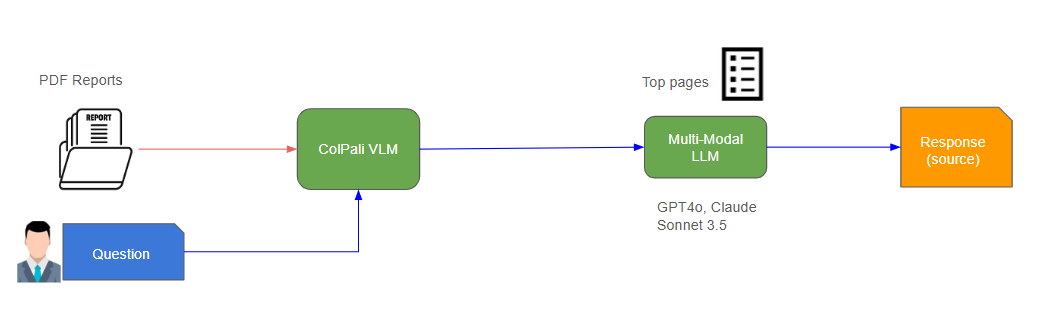

### 1. Install Libraries & Imports

In [ ]:
!pip install pdf2image
!pip install colpali-engine==0.3.9
!sudo apt-get install poppler-utils

In [ ]:
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from pdf2image import convert_from_path
from torch.utils.data import DataLoader
from colpali_engine.models import ColPali, ColPaliProcessor

### 2. Loading Visual Language Model (VLM): ColPali

In [ ]:
model_name = "vidore/colpali-v1.3"

model = ColPali.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="auto",  # or "mps" if on Apple Silicon
).eval()

processor = ColPaliProcessor.from_pretrained(model_name)

### 3. Ingest PDF Data as Embeddings

In [ ]:
images = convert_from_path('/content/google-alphabet-2024.pdf')
print("Number of pages:", len(images))

In [ ]:
dataloader = DataLoader(images,
                        batch_size=1,
                        shuffle=False,
                        collate_fn=lambda x: processor.process_images(x).to(model.device))

In [ ]:
dataset = []
for batch in tqdm(dataloader):
  with torch.no_grad():
    batch = {k: v.to(model.device) for k,v in batch.items()}
    embeddings = model(**batch)
  dataset.extend(list(torch.unbind(embeddings.to("cpu").to(torch.float32))))

In [ ]:
query = ["What is the revenue from Google Cloud for 2023 and 2024 ?"]

batch_queries = processor.process_queries(query).to(model.device)
with torch.no_grad():
  query_embeddings = model(**batch_queries)

### 4. Scoring: Retrieve Best Match with Query

The **score_multi_vector** function is used to evaluate the similarity between multiple query vectors and document embeddings. It works by comparing different parts of a query with corresponding sections of a document, assigning a relevance score based on their match.

How It Works ?
1. <i>Breaks Down the Query</i> - Splits the query into multiple vectors.
2. <i>Matches Against Document Patches</i> - Each query vector is compared with different sections (patches) of the document.
3. <i>Computes Similarity Scores</i> - Calculates how well each query vector aligns with document patches using dot product similarity.
4. <i>Aggregates the Scores</i> - The final score is a sum of individual matches to rank documents.

This method ensures fine-grained retrieval also called <i>Late-Interation</i>, making it useful for visual document search where both text and layout matter

In [ ]:
def score(query_embedding, dataset):
  scores = processor.score_multi_vector(query_embedding, dataset)
  scores = np.array(scores)
  matched_pages = scores.flatten().argsort()[::-1]
  return scores, matched_pages

In [ ]:
scores, matched_pages = score(list(torch.unbind(query_embeddings.to("cpu").to(torch.float32))),dataset)
scores, matched_pages

In [ ]:
fig, ax = plt.subplots(figsize=(16, 12))
ax.imshow(images[matched_pages[0]])
ax.axis("off")
plt.show()

### 5. Load Multi-modal LLM: Qwen2.5-VL 3B

In [ ]:
!pip install qwen-vl-utils==0.0.08

In [ ]:
from qwen_vl_utils import process_vision_info
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor

In [ ]:
# default: Load the model on the available device(s)
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-Instruct", torch_dtype="auto", device_map="auto"
)


# default processer
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct")

### 6. Prepare Prompt with Retrieved Page

In [ ]:
messages = [

    {"role": "user",
     "content": [
         {"type": "image",
          "image": images[matched_pages[0]],
          "resized_height": 1024,
          "resized_width": 1024,
         },
        {"type": "text", "text": "What is the revenue from Google Cloud for 2023 and 2024 ?"}]},

]

In [ ]:
# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

### 7. Generate Answer: Model Inference

In [ ]:
# Inference: Generation of the output

with torch.no_grad():
  generated_ids = model.generate(**inputs, max_new_tokens=64)

generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)